In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *


In [2]:
# Hyperparameters and paths

first_execution = False  # Set to True for the first execution to split the excel file

RAW = Path("data/raw/Observations_2012-2025.xlsx")
OUT_FILT = Path("data/filtered")
OUT_CLEAN = Path("data/cleaned")
OUT_DRAFT = Path("data/drafts")

sheets_to_csv_filtered = {
    "ESPECES": "especes.csv",
    "GPS-MILIEU": "gps_milieu.csv",
    "NOM FRANÇAIS": "observations.csv",
}

sheets_to_csv_cleaned = {
    "ESPECES": "especes_clean.csv",
    "GPS-MILIEU": "gps_milieu_clean.csv",
    "NOM FRANÇAIS": "nom_francais_clean.csv",
}


In [3]:
# Original sheets declaration : 

# Run on the first execution to split and save the excel file into multiple csv files
if first_execution:
    print(split_excel_to_csvs(RAW, OUT_FILT, sheets_to_csv_filtered))

# For following executions, load the csv files directly
dfs = load_csvs(OUT_FILT, sheets_to_csv_filtered)
for k, df in dfs.items():
    print(f"{k}: {df.shape}")


# Visual inspection of dataframes, uncoment as needed
# dfs['ESPECES'].head()
# dfs['GPS-MILIEU'].head()
# dfs['NOM FRANÇAIS'].head()

ESPECES: (86, 5)
GPS-MILIEU: (651, 8)
NOM FRANÇAIS: (114497, 26)


In [4]:
# Cleaned dataframes declaration 

if first_execution:
    # Cleaning dataframes from initial loading issues
    clean_especes = clean_especes(dfs["ESPECES"])
    clean_gps = clean_gps(dfs["GPS-MILIEU"])
    clean_nom_francais = clean_observations(dfs["NOM FRANÇAIS"])

    # Saving cleaned dataframes back to csv files
    save_clean_csvs({"ESPECES": clean_especes, "GPS-MILIEU": clean_gps, "NOM FRANÇAIS": clean_nom_francais}, OUT_CLEAN)

else:
    # Loading cleaned dataframes directly from csv files
    clean_dfs = load_csvs(OUT_CLEAN, sheets_to_csv_cleaned)
    clean_especes = clean_dfs["ESPECES"]
    clean_gps = clean_dfs["GPS-MILIEU"]
    clean_nom_francais = clean_dfs["NOM FRANÇAIS"]

# uncomment as needed to inspect cleaned dataframes
# clean_especes.head()
# clean_gps.head()
# clean_nom_francais.head()

In [5]:
clean_especes.head()

,ESPECIES_NAME,LATIN_NAME,NATURE
0,Aigrette bleue,Egretta caerulea,Migrateur
1,Aigrette garzette,Egretta garzetta,Migrateur
2,Aigrette neigeuse,Egretta thula,Migrateur
3,Aigrette tricolore,Egretta tricolor ruficollis,Migrateur
4,Amazone aourou,Amazona amazonica,Exogène introduit par l'homme


## Dataset orientation summaries

In [6]:
print("Data orientation summaries : ")
print(f"- Especes : {clean_especes.shape}")
print(f"- GPS : {clean_gps.shape}")
print(f"- Nom Français : {clean_nom_francais.shape}")

Data orientation summaries : 
- Especes : (87, 3)
- GPS : (650, 6)
- Nom Français : (114495, 26)


---

## Especes : 

In [7]:
df = clean_especes.copy()

# Basic structure and uniqueness check ------------------------------------
print("Number of species:", len(df))
print("Unique ESPECIES_NAME:", df["ESPECIES_NAME"].nunique())
print("Unique LATIN_NAME:", df["LATIN_NAME"].nunique())

# Check for duplicates
dup_species = df[df["ESPECIES_NAME"].duplicated(keep=False)].sort_values("ESPECIES_NAME")
dup_latin   = df[df["LATIN_NAME"].duplicated(keep=False)].sort_values("LATIN_NAME")

print("Duplicated:")
display(dup_species)


Number of species: 87
Unique ESPECIES_NAME: 86
Unique LATIN_NAME: 86
Duplicated:


,ESPECIES_NAME,LATIN_NAME,NATURE
7,Astrild ondulé,Estrilda astrild,Exogène introduit par l'homme
8,Astrild ondulé,Estrilda astrild,Exogène introduit par l'homme


In [8]:
# "Families" aer defined by a shared root ------------------------------------
df["ESPECIES_FAMILY"] = df["ESPECIES_NAME"].str.split().str[0]
df["LATIN_FAMILY"] = df["LATIN_NAME"].str.split().str[0]

# Count distinct families
especies_families = df["ESPECIES_FAMILY"].value_counts().reset_index()
especies_families.columns = ["ESPECIES_FAMILY", "N_ESPECIES"]

latin_families = df["LATIN_FAMILY"].value_counts().reset_index()
latin_families.columns = ["LATIN_FAMILY", "N_ESPECIES"]
    
# Also build Python dictionaries
species_family_dict = dict(zip(especies_families["ESPECIES_FAMILY"], especies_families["N_ESPECIES"]))
latin_family_dict = dict(zip(latin_families["LATIN_FAMILY"], latin_families["N_ESPECIES"]))

print("French name families (count):", len(species_family_dict))
print("Latin name families (count):", len(latin_family_dict))

print("Top 10 families (by French names):")
display(especies_families.head(10))
print("Top 10 families (by Latin names):")
display(latin_families.head(10))


French name families (count): 53
Latin name families (count): 71
Top 10 families (by French names):


,ESPECIES_FAMILY,N_ESPECIES
0,Aigrette,4
1,Astrild,4
2,Colibri,4
3,Chevalier,4
4,Moqueur,4
5,Sterne,4
6,Sporophile,3
7,Hirondelle,3
8,Tourterelle,3
9,Colombe,3


Top 10 families (by Latin names):


,LATIN_FAMILY,N_ESPECIES
0,Egretta,4
1,Estrilda,4
2,Tringa,3
3,Falco,3
4,Eulampis,2
5,Lonchura,2
6,Geotrygon,2
7,Onychoprion,2
8,Ardea,2
9,Zenaida,2


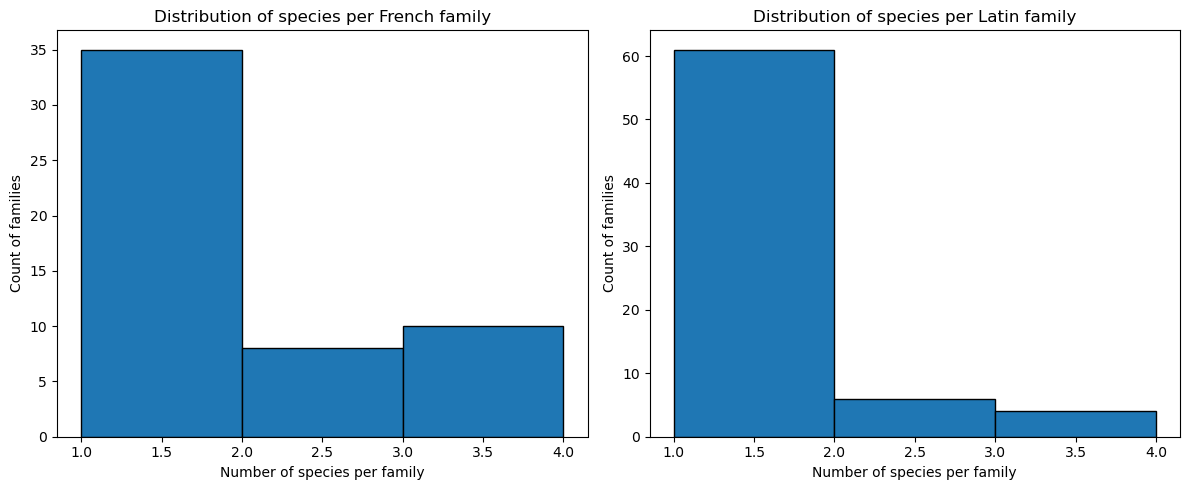

In [9]:
# Plot distribution of family sizes ------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(especies_families["N_ESPECIES"], bins=range(1, especies_families["N_ESPECIES"].max()+1), edgecolor='black')
axes[0].set_title("Distribution of species per French family")
axes[0].set_xlabel("Number of species per family")
axes[0].set_ylabel("Count of families")

axes[1].hist(latin_families["N_ESPECIES"], bins=range(1, latin_families["N_ESPECIES"].max()+1), edgecolor='black')
axes[1].set_title("Distribution of species per Latin family")
axes[1].set_xlabel("Number of species per family")
axes[1].set_ylabel("Count of families")
plt.tight_layout()
plt.show()



Distinct NATURE values:
NATURE
Migrateur                         24
Autochtone                        19
Exogène introduit par l'homme     15
Endémique des Petites Antilles    13
Marin                              8
Exogène colonisateur naturel       4
Endémique de la Martinique         2
Migrateur rare                     1
Name: count, dtype: int64
Nature distribution per family:


,ESPECIES_FAMILY,NATURE,count
0,Aigrette,Migrateur,4
1,Amazone,Exogène introduit par l'homme,1
2,Astrild,Exogène introduit par l'homme,3
3,Balbuzard,Migrateur,1
4,Bengali,Exogène introduit par l'homme,1
5,Bihoreau,Autochtone,1
6,Bihoreau,Migrateur,1
7,Bécasseau,Migrateur,1
8,Canard,Exogène introduit par l'homme,1
9,Capucin,Exogène introduit par l'homme,2


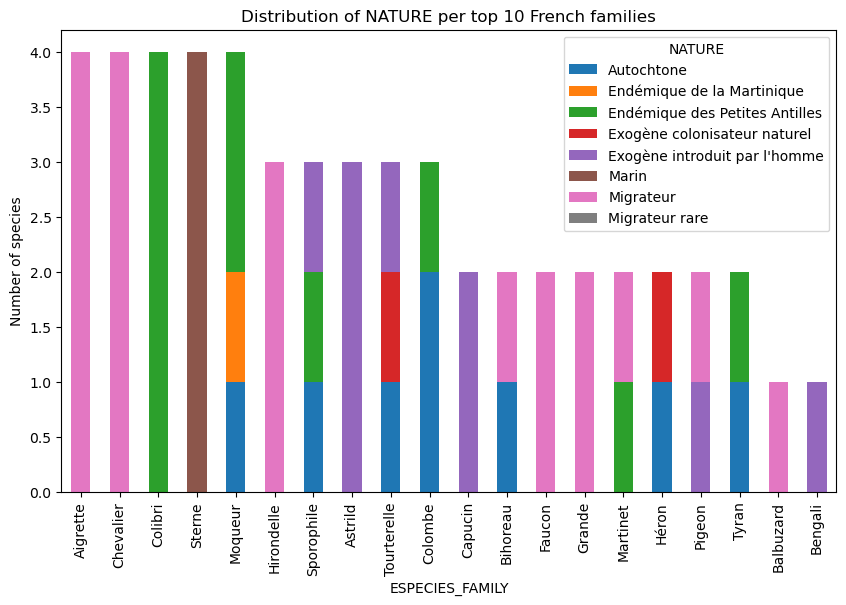

In [10]:
# NATURE analysis ------------------------------------
print("Distinct NATURE values:")
print(df["NATURE"].value_counts())

# Distribution of NATURE per family ------------------------------------
nature_by_family = (
    df.groupby(["ESPECIES_FAMILY", "NATURE"])
      .size()
      .reset_index(name="count")
)

print("Nature distribution per family:")
display(nature_by_family.sort_values(["ESPECIES_FAMILY", "count"], ascending=[True, False]).head(10))

# Pivot to make a clearer table
nature_pivot = nature_by_family.pivot_table(
    index="ESPECIES_FAMILY", columns="NATURE", values="count", fill_value=0
).astype(int)

# Plot top 10 families by total species
top_fams = nature_pivot.sum(axis=1).sort_values(ascending=False).head(20).index
nature_pivot.loc[top_fams].plot(
    kind="bar", stacked=True, figsize=(10, 6),
    title="Distribution of NATURE per top 10 French families"
)
plt.ylabel("Number of species")
plt.show()


#### Key insights for the ESPECES table :

TBD 

---

- GPS :

In [11]:
df = clean_gps.copy()

# Count distinct habitat types ------------------------------------
n_habitats = df["HABITAT_TYPE"].nunique()
print(f"Number of distinct habitat types: {n_habitats}")
print("Habitat types frequency:")
print(df["HABITAT_TYPE"].value_counts())

# Link habitat types to unique transect names ------------------------------------
# Remove duplicates so that each (habitat, transect_name) pair appears only once
habitat_transect = (
    df[["HABITAT_TYPE", "TRANSECT_NAME"]]
    .drop_duplicates()
    .sort_values(["HABITAT_TYPE", "TRANSECT_NAME"])
)

# For each habitat type, list unique transects
habitat_to_transects = (
    habitat_transect.groupby("HABITAT_TYPE")["TRANSECT_NAME"]
    .apply(list)
    .to_dict()
)

# Display summary ------------------------------------
print("Habitat type → number of unique transects:")
for habitat, transects in habitat_to_transects.items():
    print(f"- {habitat}: {len(transects)} transects")


Number of distinct habitat types: 7
Habitat types frequency:
HABITAT_TYPE
Forêt sèche     186
Agricole        134
Forêt humide    130
Périurbain      120
Mangrove         30
Plage            30
Urbain           20
Name: count, dtype: int64
Habitat type → number of unique transects:
- Agricole: 14 transects
- Forêt humide: 13 transects
- Forêt sèche: 19 transects
- Mangrove: 3 transects
- Plage: 3 transects
- Périurbain: 12 transects
- Urbain: 2 transects


In [12]:
print(70*"=")
# Optional: show a few examples
for habitat, transects in list(habitat_to_transects.items()):
    print(f"\n{habitat} ({len(transects)} transects):")
    print(transects)

# make a summary DataFrame and plot ------------------------------------
habitat_summary = (
    pd.DataFrame({
        "HABITAT_TYPE": list(habitat_to_transects.keys()),
        "N_TRANSECTS": [len(v) for v in habitat_to_transects.values()]
    })
    .sort_values("N_TRANSECTS", ascending=False)
)


Agricole (14 transects):
['Bois Pothau', 'Canal Cocotte', 'Cap Est', 'Carrère', 'Fonds Préville', 'Galion', 'Galion 2', 'Génipa', 'Habitation Petite Rivière', 'Hôtel des Plaisirs', 'Lafayette', 'Morne Babet', 'Moulin à Vent', 'Verrier']

Forêt humide (13 transects):
['Anse Couleuvre', 'Bois La Charles', 'Bouliki', "Domaine d'Emeraude", 'Fond Baron', "Fond l'Etang", 'Forêt Montravail', 'Forêt la Reculée', 'La Démarche 2', "Rivière l'Or", 'Route Forestière de Palourde', 'Tunnel Didier', 'Tunnel Didier 2']

Forêt sèche (19 transects):
['Anse Mathurin', 'Blin', 'Bois Pothau', 'Forêt Vatable', 'Forêt Vatable 2', 'Forêt la Philippe', 'Ilets du François', 'Ilets du Robert', 'Le Phare-Caravelle', 'Morne Bellevue', 'Morne Gardier', 'Petit Sentier RNC', 'Piton Crève-cœur', 'Pointe Banane', 'Pointe Jean-Claude', 'Pointe La Rose', 'Pointe Lynch', 'Pointe Rouge', 'Rocher Leclerc']

Mangrove (3 transects):
['Aéroport', 'Boucle du Vauclin', 'Morne Cabri']

Plage (3 transects):
['Anse Meunier', 'Autr

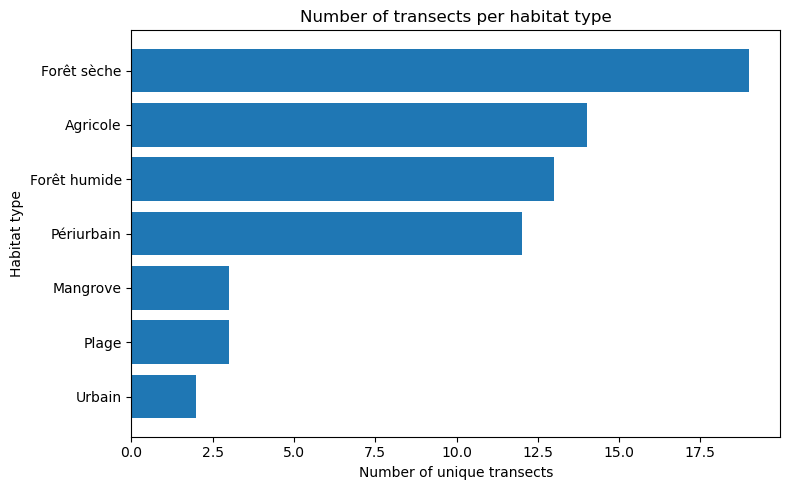

In [13]:
# Bar plot: how many transects per habitat type

plt.figure(figsize=(8, 5))
plt.barh(habitat_summary["HABITAT_TYPE"], habitat_summary["N_TRANSECTS"])
plt.xlabel("Number of unique transects")
plt.ylabel("Habitat type")
plt.title("Number of transects per habitat type")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Key insights for the GPS-MILIEU table :

TBD 

---

### Nom Français : 

,year,N_observations,N_species,Total_birds,Mean_birds_per_obs
0,2014.0,5378,64,11217.000000,2.085720
1,2015.0,8162,70,17815.000000,2.182676
2,2016.0,11011,78,23285.000000,2.114703
3,2017.0,9228,71,20644.809524,2.237192
4,2018.0,9733,73,20556.000000,2.111990
5,2019.0,9572,70,21196.333333,2.214410
6,2020.0,9956,68,22199.000000,2.229711
7,2021.0,10604,69,24220.000000,2.284044
8,2022.0,10804,68,24714.000000,2.287486
9,2023.0,10224,67,22545.000000,2.205106


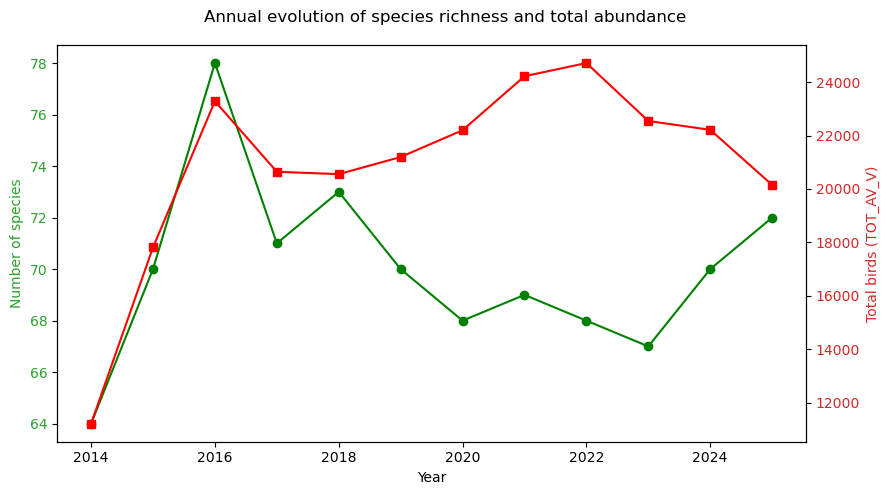

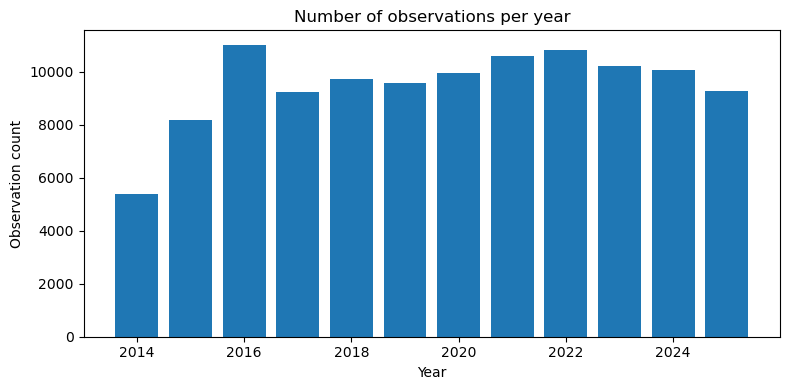

In [14]:
# Assume the cleaned observations table is already loaded:
# df_obs = pd.read_csv("data/filtered/observations_clean.csv")

df = clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Basic yearly counts ---
annual_summary = (df.groupby("year").agg(
          N_observations=("ESPECE", "size"),
          N_species=("ESPECE", "nunique"),
          Total_birds=("TOT_AV_V", "sum"),
          Mean_birds_per_obs=("TOT_AV_V", "mean")
        ).reset_index()
)

display(annual_summary)

# --- Plot species richness and total abundance per year ---
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.plot(annual_summary["year"], annual_summary["N_species"], marker="o", color="green", label="Species richness")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of species", color="tab:green")
ax1.tick_params(axis="y", labelcolor="tab:green")

ax2 = ax1.twinx()
ax2.plot(annual_summary["year"], annual_summary["Total_birds"], marker="s", color="red", label="Total birds")
ax2.set_ylabel("Total birds (TOT_AV_V)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.suptitle("Annual evolution of species richness and total abundance")
plt.tight_layout()
plt.show()

# --- Histogram: number of observations per year ---
plt.figure(figsize=(8,4))
plt.bar(annual_summary["year"], annual_summary["N_observations"], color="tab:blue")
plt.title("Number of observations per year")
plt.xlabel("Year")
plt.ylabel("Observation count")
plt.tight_layout()
plt.show()


,Nom observateur,N_observations,N_years,N_species_seen,Mean_birds,Total_birds
19,CONDE Beatriz,41435,12,79,2.198439,91092.333333
6,BAHUAUD Anthony,8719,10,65,2.154949,18789.000000
10,BELFAN David,7331,12,48,2.924703,21441.000000
36,MAUGEE Lévy,6838,12,47,2.068587,14145.000000
5,AUGUSTE Christophe,5054,12,40,1.700200,8592.809524
35,MARRAUD des GROTTES Roland,4229,12,40,1.551904,6563.000000
3,ALEXANDRINE Thomas,3154,12,30,1.679455,5297.000000
40,PICARD Rémi,3116,4,44,2.561938,7983.000000
38,MOURIESSE Jocelyne,3093,12,47,2.354672,7283.000000
47,VALSIN Michel,2284,9,40,2.577496,5887.000000


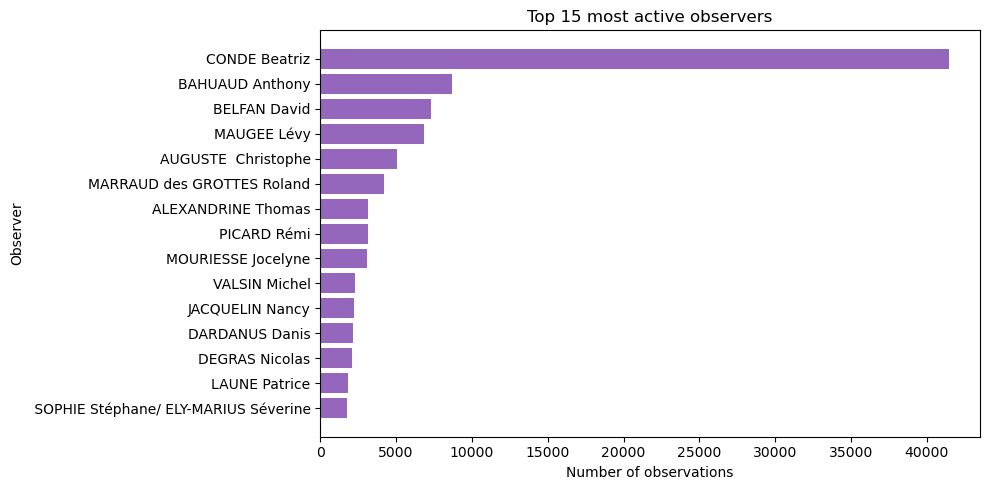

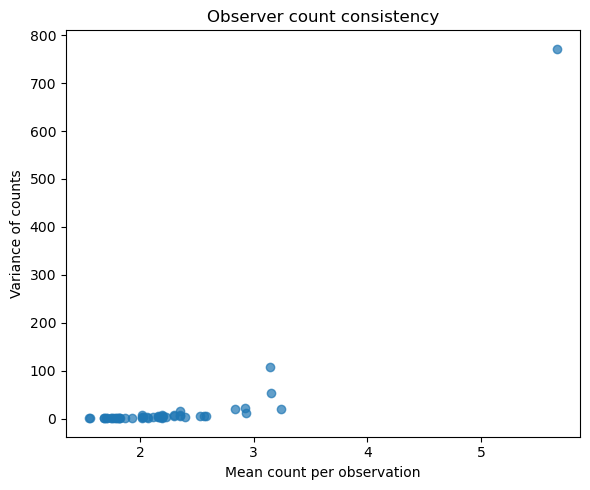

,Nom observateur,Mean_count,Variance,count
2,AGAT Arnaud-FREMACX Vincent- NOSEL Christopher,5.666667,771.626667,51
11,BELLUMEUR Wilfrid,3.142857,107.331800,1554
43,ROLLIN Michaël,3.149718,53.765057,354
10,BELFAN David,2.924703,21.324207,7331
28,FLERIAG Lyneda,2.832011,20.783663,756
32,LABONNE Annick,3.243011,20.399870,465
38,MOURIESSE Jocelyne,2.354672,15.801399,3093
31,JACQUELIN Nancy,2.934938,11.072002,2244
18,CHANTEUR Bénédicte,2.293651,7.877812,504
20,CONDE Beatriz,2.350725,7.181867,345


In [15]:
# --- Observer participation summary ---
observer_summary = (
    df.groupby("Nom observateur")
      .agg(
          N_observations=("ESPECE", "size"),
          N_years=("year", "nunique"),
          N_species_seen=("ESPECE", "nunique"),
          Mean_birds=("TOT_AV_V", "mean"),
          Total_birds=("TOT_AV_V", "sum")
      )
      .reset_index()
      .sort_values("N_observations", ascending=False)
)

display(observer_summary.head(10))

# --- Plot: top observers by number of observations ---
plt.figure(figsize=(10,5))
top_obs = observer_summary.head(15)
plt.barh(top_obs["Nom observateur"], top_obs["N_observations"], color="tab:purple")
plt.xlabel("Number of observations")
plt.ylabel("Observer")
plt.title("Top 15 most active observers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Observer consistency: mean vs variance of counts ---
# (A simple reliability proxy — stable observers have low variance in total counts)
observer_variability = (
    df.groupby("Nom observateur")["TOT_AV_V"]
      .agg(["mean", "var", "count"])
      .rename(columns={"mean": "Mean_count", "var": "Variance"})
      .reset_index()
)

plt.figure(figsize=(6,5))
plt.scatter(observer_variability["Mean_count"], observer_variability["Variance"], alpha=0.7)
plt.xlabel("Mean count per observation")
plt.ylabel("Variance of counts")
plt.title("Observer count consistency")
plt.tight_layout()
plt.show()

# Observers with very high variance relative to mean may indicate inconsistent detection
display(observer_variability.sort_values("Variance", ascending=False).head(10))


In [ ]:

# Assume df_obs is your cleaned observations DataFrame
df = clean_nom_francais.copy()

# Unique mapping of observer ↔ transect (ignoring point duplicates)
observer_transect = (
    df[["Nom observateur", "Nom transect"]]
    .drop_duplicates()
    .sort_values(["Nom observateur", "Nom transect"])
)

print(f"Total unique observer-transect pairs: {len(observer_transect)}")
display(observer_transect.head(10))

# For each observer, list all transects they have worked on
observer_to_transects = (
    observer_transect.groupby("Nom observateur")["Nom transect"]
    .apply(list)
    .to_dict()
)

# Example output: {"Alice": ["Transect_1", "Transect_4"], "Bob": ["Transect_2"], ...}
print("Example observer to transects mapping:")
for k, v in list(observer_to_transects.items())[:5]:
    print(f"- {k}: {len(v)} transects → {v[:5]}")


Total unique observer–transect pairs: 142


,Nom observateur,Nom transect
82826,SOPHIE Stéphane/ ELY-MARIUS Séverine,Habitation Petite Rivière
76732,SOPHIE Stéphane/ ELY-MARIUS Séverine,Moulin à Vent
18582,VALSIN Michel,Morne Bellevue
109532,AGAT Arnaud-FREMACX Vincent- NOSEL Christopher,Ilets du François
47188,ALEXANDRINE Thomas,Le Phare-Caravelle
4919,ALEXANDRINE Thomas,Petit Sentier RNC
4867,ALEXANDRINE Thomas,Pointe Rouge
113860,ALEXANDRINE Thomas,Le Phare-Caravelle
113815,ALEXANDRINE Thomas,Petit Sentier RNC
113961,ALEXANDRINE Thomas,Pointe Rouge


Example observer to transects mapping:
-  SOPHIE Stéphane/ ELY-MARIUS Séverine: 2 transects → ['Habitation Petite Rivière', 'Moulin à Vent']
-  VALSIN Michel: 1 transects → ['Morne Bellevue']
- AGAT Arnaud-FREMACX Vincent- NOSEL Christopher: 1 transects → ['Ilets du François']
- ALEXANDRINE Thomas: 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']
- ALEXANDRINE Thomas : 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']


In [23]:
observer_to_transects

{' SOPHIE Stéphane/ ELY-MARIUS Séverine': ['Habitation Petite Rivière',
  'Moulin à Vent'],
 ' VALSIN Michel': ['Morne Bellevue'],
 'AGAT Arnaud-FREMACX Vincent- NOSEL Christopher': ['Ilets du François'],
 'ALEXANDRINE Thomas': ['Le Phare-Caravelle',
  'Petit Sentier RNC',
  'Pointe Rouge'],
 'ALEXANDRINE Thomas ': ['Le Phare-Caravelle',
  'Petit Sentier RNC',
  'Pointe Rouge'],
 'AUGUSTE  Christophe': ['ANSE COULEUVRE',
  'Anse Couleuvre',
  "Domaine d'Emeraude",
  'Fond Baron',
  'Fond Baron ',
  'Route Forestière de Palourde'],
 'BAHUAUD Anthony': ['Bouliki',
  'Canal Cocotte',
  'Desmarinière',
  'Desmarinières',
  'Génipa',
  'Lafayette',
  'Là-Haut'],
 'BAHUAUD Anthony ': ['Génipa', 'Là-Haut'],
 'BARBET Christophe': ['Bouliki'],
 'BATIFOULIER Sébastien': ['Fonds Préville', 'Forêt La Philippe'],
 'BELFAN David': ["Fond l'Etang",
  'Fort de France Centre Ville',
  'Pointe La Rose',
  'Tunnel Didier',
  'Tunnel Didier ',
  'Tunnel Didier 2'],
 'BELLUMEUR Wilfrid': ['Ilets du Robert'

In [25]:
# Count total observations (rows) per observer
obs_per_observer = (
    df.groupby("Nom observateur")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("\\nTop 10 most active observers:")
display(obs_per_observer.head(10))

# Count total observations per transect
obs_per_transect = (
    df.groupby("Nom transect")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("\\nTop 10 most observed transects:")
display(obs_per_transect.head(10))



\nTop 10 most active observers:


,Nom observateur,N_observations
19,CONDE Beatriz,41435
6,BAHUAUD Anthony,8719
10,BELFAN David,7331
36,MAUGEE Lévy,6838
5,AUGUSTE Christophe,5054
35,MARRAUD des GROTTES Roland,4229
3,ALEXANDRINE Thomas,3154
40,PICARD Rémi,3116
38,MOURIESSE Jocelyne,3093
47,VALSIN Michel,2284


\nTop 10 most observed transects:


,Nom transect,N_observations
50,Morne Babet,2878
38,Habitation Petite Rivière,2821
55,Moulin à Vent,2792
47,Là-Haut,2383
39,Hôtel des Plaisirs,2366
4,Autre Bord,2334
11,Borelie,2287
24,Fond Rousseau,2253
42,Jeannot,2222
56,O'Mullane,2203


In [28]:
# Extract year from date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Ensure weather covariates are numeric (in case they were strings)
weather_cols = ["nuages", "pluie", "vent", "visibilité"]
df[weather_cols] = df[weather_cols].apply(pd.to_numeric, errors="coerce")

transect_year_stats = (
    df.groupby(["Nom transect", "year"])[weather_cols]
      .mean()
      .reset_index()
)

# Add number of observations for each transect-year
transect_obs_count = (
    df.groupby(["Nom transect", "year"])
      .size()
      .reset_index(name="N_observations")
)
transect_year_stats = transect_year_stats.merge(transect_obs_count, on=["Nom transect", "year"])

display(transect_year_stats.head(10))


,Nom transect,year,nuages,pluie,vent,visibilité,N_observations
0,ANSE COULEUVRE,2019.0,1.757282,1.213592,1.339806,1.582524,103
1,Anse Couleuvre,2014.0,1.750000,1.086538,1.250000,1.423077,104
2,Anse Couleuvre,2015.0,1.892562,1.057851,2.000000,2.000000,121
3,Anse Couleuvre,2016.0,2.228070,1.087719,1.061404,1.447368,114
4,Anse Couleuvre,2017.0,1.978495,1.204301,1.000000,1.634409,93
5,Anse Couleuvre,2018.0,1.220930,1.034884,1.000000,1.139535,86
6,Anse Couleuvre,2020.0,2.000000,1.207547,1.886792,1.735849,53
7,Anse Couleuvre,2021.0,1.517241,1.189655,1.000000,1.344828,116
8,Anse Couleuvre,2022.0,3.000000,1.769231,2.175824,2.505495,91
9,Anse Couleuvre,2023.0,2.000000,1.310924,2.134454,1.689076,119


,ESPECE,year,N_observations
0,Aigrette bleue,2014.0,1
1,Aigrette bleue,2015.0,2
2,Aigrette bleue,2016.0,3
3,Aigrette bleue,2020.0,3
4,Aigrette bleue,2024.0,1
5,Aigrette neigeuse,2014.0,6
6,Aigrette neigeuse,2015.0,13
7,Aigrette neigeuse,2016.0,23
8,Aigrette neigeuse,2017.0,17
9,Aigrette neigeuse,2018.0,25


,ESPECE,N_years_observed
1,Aigrette neigeuse,12
3,Amazone aourou,12
20,Chevalier grivelé,12
17,Capucin à tête blanche,12
12,Bihoreau violacé,12
8,Astrild à joues orange,12
7,Astrild ondulé,12
27,Colombe rouviolette,12
35,Elénie siffleuse,12
32,Coulicou manioc,12


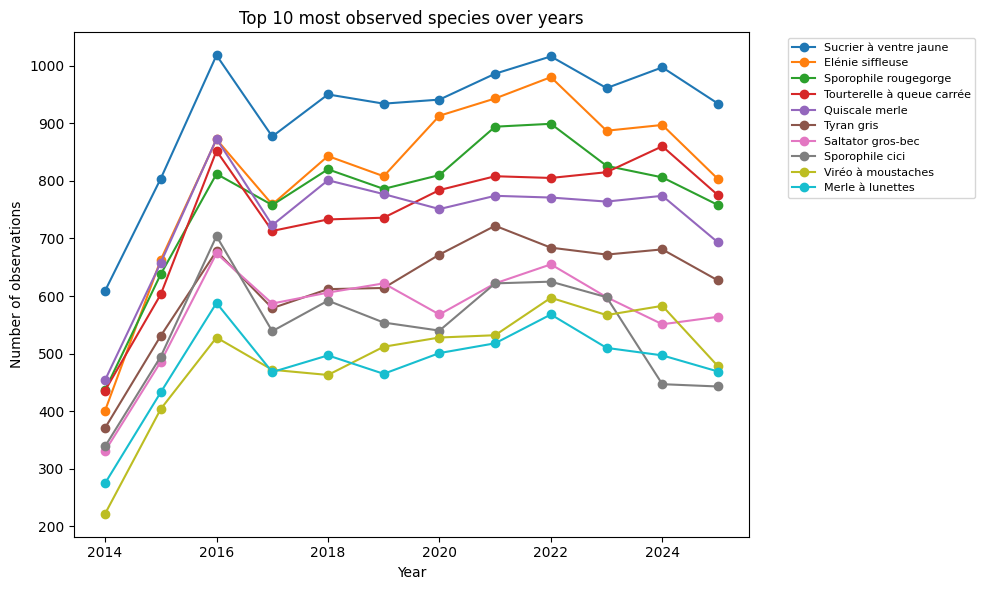

In [30]:

# Assume you have:
# df_obs = pd.read_csv("data/filtered/observations_clean.csv")
# df_especes = pd.read_csv("data/filtered/especes_clean.csv")

df = clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Count number of observations per species per year ---
species_year_counts = (
    df.groupby(["ESPECE", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["ESPECE", "year"])
)

display(species_year_counts.head(10))

# --- Total number of years each species was observed ---
species_total = (
    species_year_counts.groupby("ESPECE")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(species_total.head(10))

# --- Example: plot top 10 most observed species over time ---
top_species = (
    species_year_counts.groupby("ESPECE")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for specie in top_species:
    subset = species_year_counts[species_year_counts["ESPECE"] == specie]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=specie)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed species over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()


,FAMILY,year,N_observations
0,Aigrette,2014.0,7
1,Aigrette,2015.0,15
2,Aigrette,2016.0,26
3,Aigrette,2017.0,17
4,Aigrette,2018.0,25
5,Aigrette,2019.0,26
6,Aigrette,2020.0,21
7,Aigrette,2021.0,15
8,Aigrette,2022.0,15
9,Aigrette,2023.0,17


,FAMILY,N_years_observed
0,Aigrette,12
1,Amazone,12
2,Astrild,12
5,Bihoreau,12
19,Gallinule,12
10,Colibri,12
9,Chevalier,12
8,Capucin,12
11,Colombe,12
18,Frégate,12


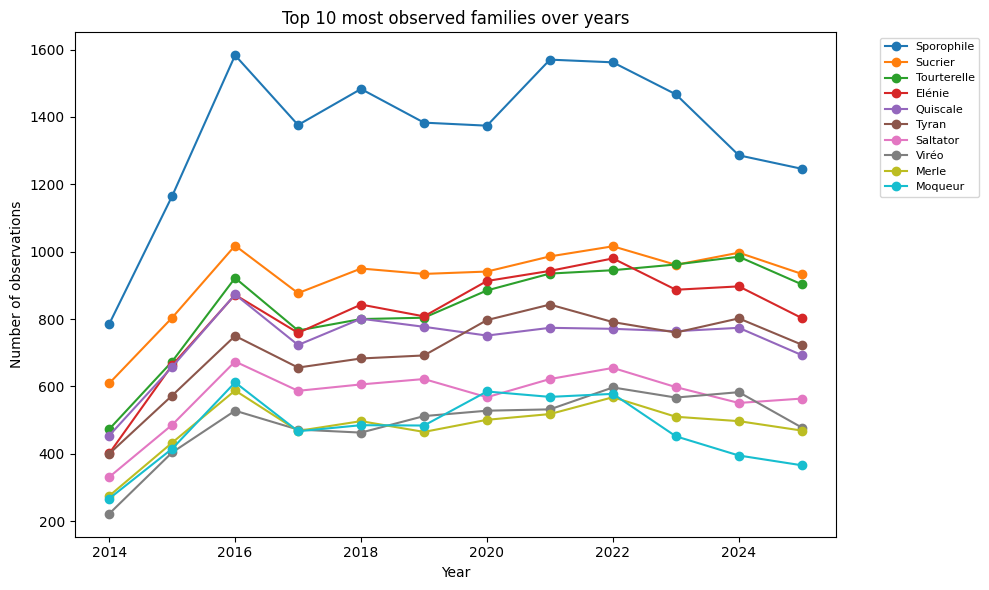

In [31]:
# Create mapping ESPECE (name) → family
clean_especes["ESPECIES_FAMILY"] = clean_especes["ESPECIES_NAME"].str.split().str[0]
species_to_family = dict(zip(clean_especes["ESPECIES_NAME"], clean_especes["ESPECIES_FAMILY"]))

# Map to observations table
df["FAMILY"] = df["ESPECE"].map(species_to_family)

# --- Count observations per family per year ---
family_year_counts = (
    df.groupby(["FAMILY", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["FAMILY", "year"])
)

display(family_year_counts.head(10))

# --- Total number of years each family observed ---
family_total = (
    family_year_counts.groupby("FAMILY")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(family_total.head(10))

# --- Plot top 10 most observed families ---
top_families = (
    family_year_counts.groupby("FAMILY")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for fam in top_families:
    subset = family_year_counts[family_year_counts["FAMILY"] == fam]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=fam)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed families over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()


***Case Study of most visited transects, and enough observable birds for each one***

For these part, we are going to try to find for each of the three most visited transects, the relation between the sighting/hearing of birds of the same species with the environmental change of the zone.

Top 3 transects (by visits): ['Morne Babet', 'Habitation Petite Rivière', 'Moulin à Vent']


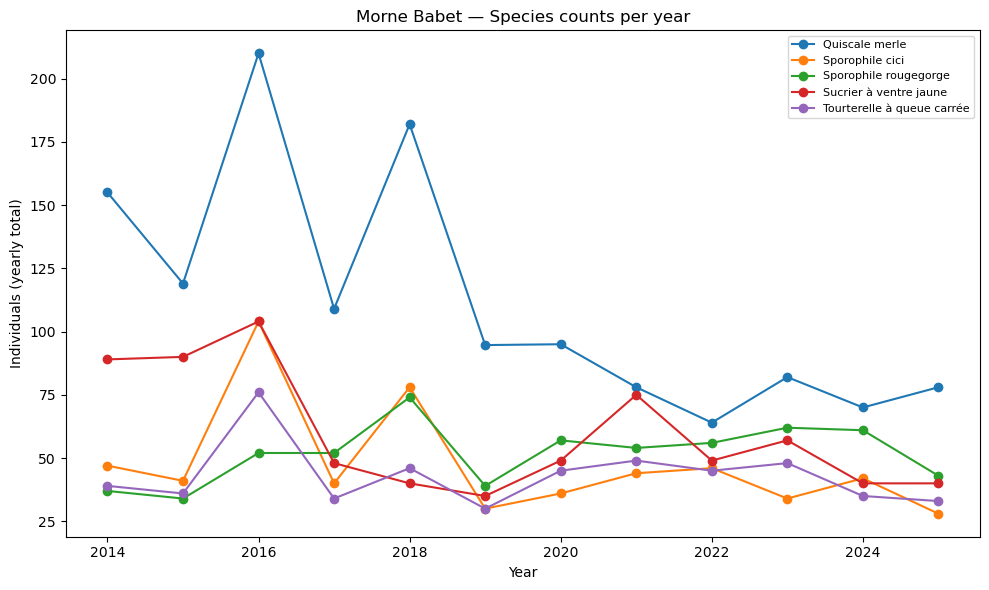

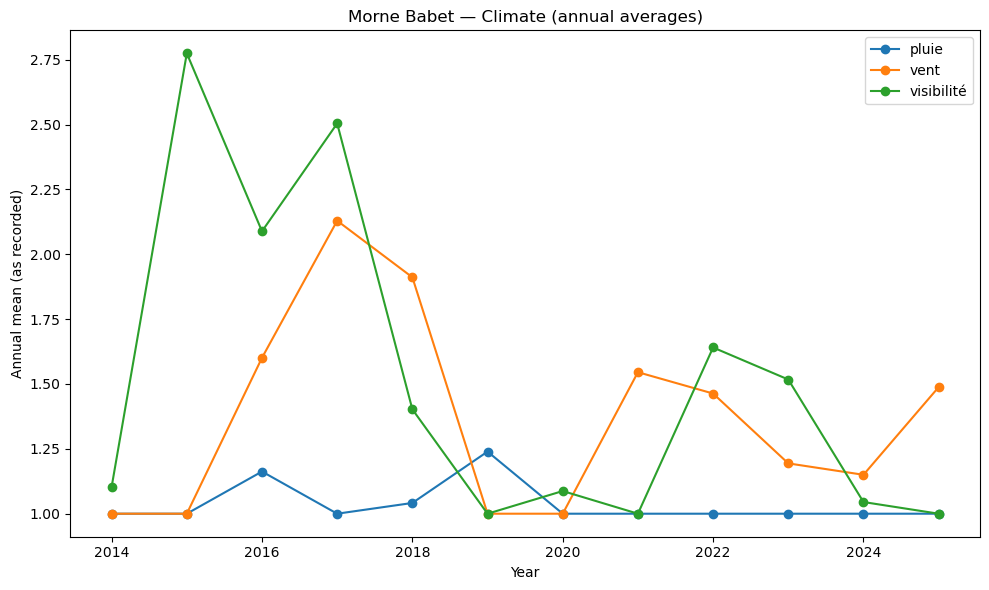

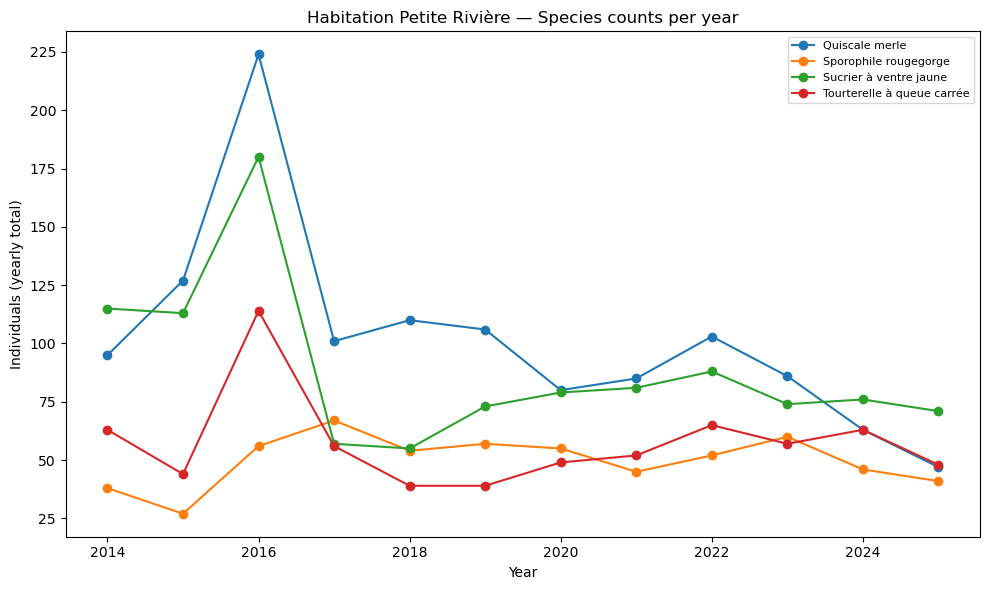

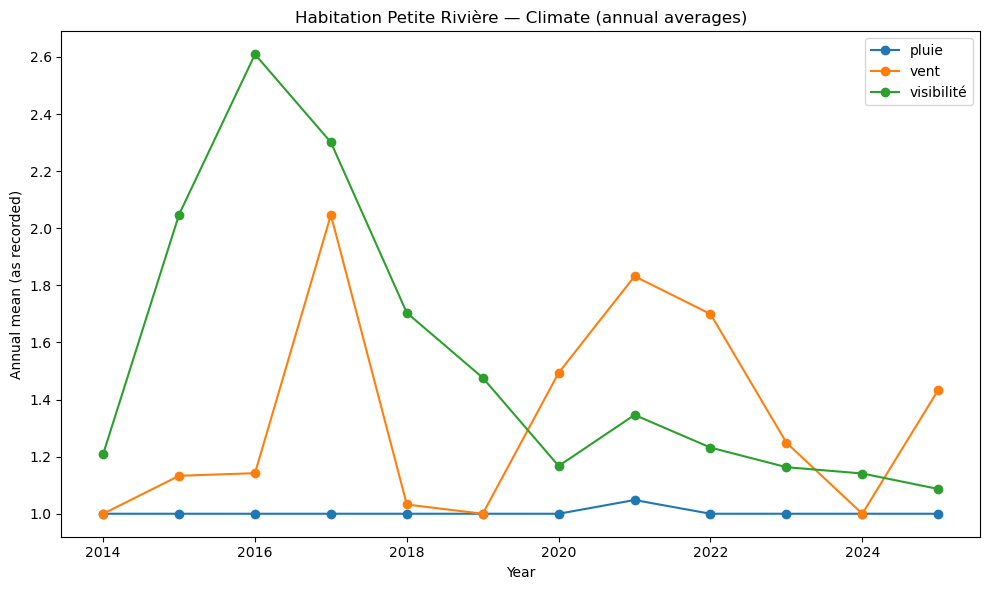

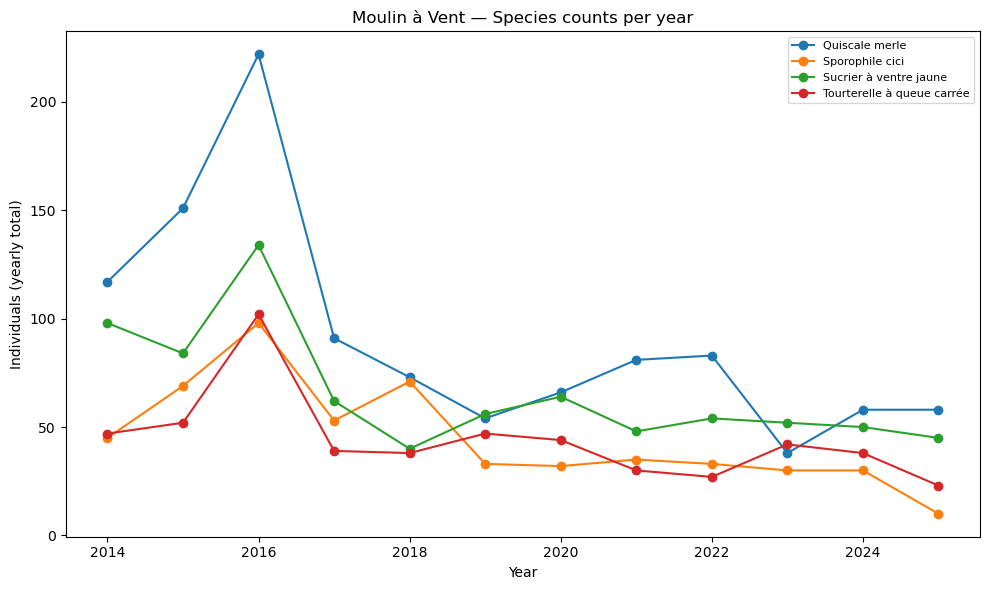

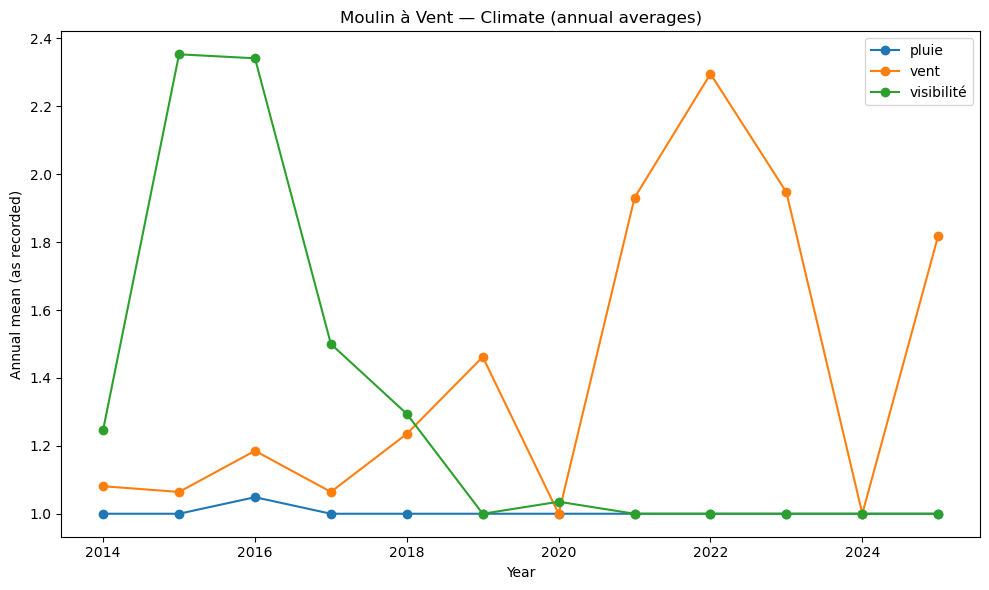

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# USER SETTINGS
N = 500          # keep species with total count > N within the transect
N_years = 5     # and present in at least N_years
SAVE_DIR = None # e.g., "outputs/plots"; None = don't save to disk
# ---------------------------------------

df = clean_nom_francais.copy()

# --- Basic hygiene ---
# ensure datetime and year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# standardize key column names used below
COL_TRANSECT = "Nom transect"
COL_SPECIES  = "ESPECE"

df["count_val"] = pd.to_numeric(df["TOT_AV_sV"], errors="coerce").fillna(0)

# --- Find top 3 transects by number of point-visits (rows) ---
top3_transects = (
    df.groupby(COL_TRANSECT)
      .size()
      .sort_values(ascending=False)
      .head(3)
      .index
      .tolist()
)

print("Top 3 transects (by visits):", top3_transects)

# --- climate variables we’ll summarize per year ---
climate_cols = [c for c in ["nuages","pluie","vent","visibilité"] if c in df.columns]

# --- Helper: plotting utilities (one figure per chart, no specified colors) ---
def plot_species_trends(ts_df, transect_name):
    # ts_df: index=year, columns=species, values=counts
    plt.figure(figsize=(10,6))
    for sp in ts_df.columns:
        plt.plot(ts_df.index, ts_df[sp], marker='o', label=sp)
    plt.title(f"{transect_name} — Species counts per year")
    plt.xlabel("Year")
    plt.ylabel("Individuals (yearly total)")
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    if SAVE_DIR:
        out = f"{SAVE_DIR}/{transect_name}_species_trends.png"
        plt.savefig(out, dpi=150)
    plt.show()

def plot_climate_trends(clim_df, transect_name):
    # clim_df: index=year, columns=climate vars, values=annual mean
    plt.figure(figsize=(10,6))
    for c in clim_df.columns:
        plt.plot(clim_df.index, clim_df[c], marker='o', label=c)
    plt.title(f"{transect_name} — Climate (annual averages)")
    plt.xlabel("Year")
    plt.ylabel("Annual mean (as recorded)")
    plt.legend(loc="best")
    plt.tight_layout()
    if SAVE_DIR:
        out = f"{SAVE_DIR}/{transect_name}_climate_trends.png"
        plt.savefig(out, dpi=150)
    plt.show()

# --- Main loop over top 3 transects ---
for t in top3_transects:
    sub = df[df[COL_TRANSECT] == t].copy()

    # aggregate yearly species counts
    sp_year = (sub
               .groupby(["year", COL_SPECIES], dropna=False)["count_val"]
               .sum()
               .reset_index())

    # species filters within THIS transect:
    #   (1) total count > N
    keep1 = (sp_year.groupby(COL_SPECIES)["count_val"].sum() > N)
    #   (2) present in >= N_years (years with nonzero count)
    present_years = sp_year.assign(pos=(sp_year["count_val"] > 0).astype(int)) \
                           .groupby(COL_SPECIES)["pos"].sum()
    keep2 = present_years >= N_years

    keep_species = set(keep1[keep1].index).intersection(set(keep2[keep2].index))
    sp_year_f = sp_year[sp_year[COL_SPECIES].isin(keep_species)].copy()

    # pivot to wide for plotting lines
    ts_species = (sp_year_f
                  .pivot_table(index="year", columns=COL_SPECIES, values="count_val", aggfunc="sum")
                  .fillna(0)
                  .sort_index())

    if ts_species.shape[1] == 0:
        print(f"[{t}] No species met the filters (N={N}, N_years={N_years}). Try lowering thresholds.")
    else:
        plot_species_trends(ts_species, t)

    # climate: yearly average of each climate var
    if climate_cols:
        clim_year = (sub.groupby("year", dropna=False)[climate_cols]
                        .mean(numeric_only=True)
                        .sort_index())
        plot_climate_trends(clim_year, t)
    else:
        print(f"[{t}] No climate columns found among {climate_cols}.")


In [34]:
# ===========================
# USER SETTINGS
# ===========================
N = 30                  # keep species with total count > N (within a transect)
N_years = 5             # species must be present in at least N_years (non-zero years)
METHOD = "pearson"      # "pearson" or "spearman"
MIN_YEARS_FOR_CORR = 4  # require at least this many overlapping years to compute corr
K = 20                  # how many rows per transect to display (after filtering by CORR_ABS_MIN)
CORR_ABS_MIN = 0.70     # keep only rows with |corr| >= this threshold

COL_TRANSECT = "Nom transect"
COL_SPECIES  = "ESPECE"
COUNT_COL    = "TOT_AV_sV"
CLIMATE_COLS_CANDIDATES = ["nuages", "pluie", "vent", "visibilité"]

# ===========================
# INPUT: clean_nom_francais
# ===========================
df = clean_nom_francais.copy()

# --- checks ---
for req in [COUNT_COL, COL_TRANSECT, COL_SPECIES, "date"]:
    if req not in df.columns:
        raise KeyError(f"Missing required column '{req}'. Got: {list(df.columns)}")

# --- basics ---
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year
df["count_val"] = pd.to_numeric(df[COUNT_COL], errors="coerce").fillna(0)

# --- coerce climate columns to numeric and keep only viable ones ---
climate_cols = []
for c in CLIMATE_COLS_CANDIDATES:
    if c in df.columns:
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().sum() > 0:
            df[c] = coerced
            climate_cols.append(c)

if not climate_cols:
    raise ValueError(
        f"No usable numeric climate columns found among {CLIMATE_COLS_CANDIDATES}. "
        "Map categories to numbers first if needed."
    )

# --- top 3 transects by number of visits (rows) ---
top3_transects = (
    df.groupby(COL_TRANSECT)
      .size()
      .sort_values(ascending=False)
      .head(3)
      .index
      .tolist()
)
print("Top 3 transects (by visits):", top3_transects)

# === helpers ===
def _corr(a, b, method: str):
    """Return correlation and number of aligned observations (non-NA)."""
    aligned = pd.concat([a, b], axis=1).dropna()
    if aligned.shape[0] < MIN_YEARS_FOR_CORR:
        return np.nan, aligned.shape[0]
    if method == "spearman":
        return aligned.corr(method="spearman").iloc[0, 1], aligned.shape[0]
    return aligned.corr(method="pearson").iloc[0, 1], aligned.shape[0]

# === main: build correlation ranking per transect ===
all_results = []

for t in top3_transects:
    sub = df[df[COL_TRANSECT] == t].copy()

    # yearly species counts
    sp_year = (sub.groupby(["year", COL_SPECIES], dropna=False)["count_val"]
                  .sum()
                  .reset_index())

    # base filters
    totals_by_sp = sp_year.groupby(COL_SPECIES)["count_val"].sum()
    keep1 = totals_by_sp > N
    present_years = (sp_year.assign(pos=(sp_year["count_val"] > 0).astype(int))
                             .groupby(COL_SPECIES)["pos"].sum())
    keep2 = present_years >= N_years
    keep_species = set(keep1[keep1].index).intersection(set(keep2[keep2].index))

    if not keep_species:
        print(f"[{t}] No species pass N={N} and N_years={N_years}.")
        continue

    # species time series (year x species)
    ts_species = (sp_year[sp_year[COL_SPECIES].isin(keep_species)]
                  .pivot_table(index="year", columns=COL_SPECIES, values="count_val", aggfunc="sum")
                  .sort_index()
                  .astype(float))

    # yearly climate means (only on numeric climate columns that survived coercion)
    clim_year = (sub.groupby("year", dropna=False)[climate_cols]
                   .mean(numeric_only=True)
                   .sort_index()
                   .astype(float))

    if clim_year.empty or clim_year.columns.size == 0:
        print(f"[{t}] No numeric climate data after grouping; skipping correlations.")
        continue

    # ---------- reliability metrics (per species, this transect) ----------
    species_total = ts_species.sum(axis=0)                     # total individuals
    species_years_nonzero = (ts_species > 0).sum(axis=0)      # years with non-zero counts
    species_years_all = pd.Series(ts_species.shape[0], index=ts_species.columns)  # same for each species
    # number of raw records per species in this transect (proxy for effort)
    species_records = sub.groupby(COL_SPECIES).size().reindex(ts_species.columns).fillna(0).astype(int)
    species_mean_per_nonzero_year = species_total / species_years_nonzero.replace(0, np.nan)

    # compute correlations species-vs-climate per transect
    for sp in ts_species.columns:
        y_series = ts_species[sp]
        if (y_series.fillna(0) == 0).all():
            continue

        for attr in clim_year.columns:
            x_series = clim_year[attr]
            r, nobs = _corr(y_series, x_series, METHOD)
            all_results.append({
                "transect": t,
                "species": sp,
                "attribute": attr,
                "corr": r,
                "abs_corr": np.abs(r) if pd.notna(r) else np.nan,
                "years_used": nobs,
                # reliability fields
                "species_total": float(species_total.loc[sp]),
                "species_years_nonzero": int(species_years_nonzero.loc[sp]),
                "species_years_all": int(species_years_all.loc[sp]),
                "species_records": int(species_records.loc[sp]),
                "species_mean_per_nonzero_year": float(species_mean_per_nonzero_year.loc[sp]) \
                    if pd.notna(species_mean_per_nonzero_year.loc[sp]) else np.nan
            })

# ===========================
# RESULTS + RANKING (robust)
# ===========================
corr_df = pd.DataFrame(all_results)

if corr_df.empty:
    print("No correlations computed (check thresholds / numeric climate data).")
else:
    # keep only strong correlations (and non-NaN)
    strong = corr_df["abs_corr"].notna() & (corr_df["abs_corr"] >= CORR_ABS_MIN)
    strong_df = corr_df.loc[strong].copy()

    if strong_df.empty:
        print(f"No correlations meet the |corr| >= {CORR_ABS_MIN} threshold.")
    else:
        # rank within transect among strong correlations only
        strong_df["rank_within_transect"] = (
            strong_df.groupby("transect")["abs_corr"]
                     .rank(method="dense", ascending=False)
        )
        # nullable Int64 rank (avoids IntCastingNaNError)
        strong_df["rank_within_transect"] = (
            pd.to_numeric(strong_df["rank_within_transect"], errors="coerce")
              .round(0)
              .astype("Int64")
        )

        # nice sort
        strong_df = strong_df.sort_values(
            ["transect", "rank_within_transect", "abs_corr"],
            ascending=[True, True, False],
            na_position="last"
        )

        # Display top-K strong correlations per transect
        display_cols = [
            "transect", "rank_within_transect", "species", "attribute",
            "corr", "years_used",
            "species_total", "species_years_nonzero", "species_years_all",
            "species_records", "species_mean_per_nonzero_year"
        ]

        top_k = (
            strong_df.sort_values(["transect", "abs_corr"], ascending=[True, False])
                     .groupby("transect", group_keys=False)
                     .head(K)
                     [display_cols]
                     .reset_index(drop=True)
        )

        print(f"\nStrong correlations per transect (|corr| ≥ {CORR_ABS_MIN}) + reliability metrics:")
        display(top_k)

        # Optional: save full strong set
        # strong_df[display_cols].to_csv("correlation_ranking_strong_with_reliability.csv", index=False)




Top 3 transects (by visits): ['Morne Babet', 'Habitation Petite Rivière', 'Moulin à Vent']

Strong correlations per transect (|corr| ≥ 0.7) + reliability metrics:


,transect,rank_within_transect,species,attribute,corr,years_used,species_total,species_years_nonzero,species_years_all,species_records,species_mean_per_nonzero_year
0,Habitation Petite Rivière,1,Trochilidae,nuages,-0.855732,10,48.0,10,12,37,4.800000
1,Habitation Petite Rivière,2,Sucrier à ventre jaune,nuages,-0.823956,12,1062.0,12,12,247,88.500000
2,Habitation Petite Rivière,3,Quiscale merle,visibilité,0.820458,12,1227.0,12,12,239,102.250000
3,Habitation Petite Rivière,4,Merle à lunettes,visibilité,0.747391,12,463.0,12,12,217,38.583333
4,Morne Babet,1,Sporophile curio,vent,0.893851,8,41.0,8,12,33,5.125000
5,Morne Babet,2,Sporophile curio,visibilité,0.884687,8,41.0,8,12,33,5.125000
6,Morne Babet,3,Trochilidae,visibilité,0.799469,7,31.0,7,12,22,4.428571
7,Morne Babet,4,Capucin à tête blanche,visibilité,-0.744077,5,35.0,5,12,9,7.000000
8,Morne Babet,5,Colibri huppé,vent,0.736318,11,71.0,11,12,59,6.454545
9,Morne Babet,6,Colibri falle-vert,vent,0.728289,12,49.0,12,12,41,4.083333


In [37]:
N = 30                  # keep species with total count > N (within a transect)
N_years = 5             # species must be present in at least N_years (non-zero years)
METHOD = "pearson"      # "pearson" or "spearman"
MIN_YEARS_FOR_CORR = 4  # require at least this many overlapping years to compute corr
K = 20                  # how many rows per transect to display (after filtering by CORR_ABS_MIN)
CORR_ABS_MIN = 0.50     # keep only rows with |corr| >= this threshold

# ---------------------------
# Sanity checks for reuse
# ---------------------------
_missing = [v for v in [
    "df","climate_cols","N","N_years","METHOD","MIN_YEARS_FOR_CORR",
    "K","CORR_ABS_MIN","COL_SPECIES","_corr"
] if v not in globals()]
if _missing:
    raise RuntimeError(f"Missing from previous cell: {_missing}. Run the prior cell first.")

if not climate_cols:
    raise ValueError("No usable numeric climate columns found (climate_cols is empty).")

# ---------------------------
# Build global (all-transects) time series
# ---------------------------
# Yearly species counts across ALL transects
sp_year_all = (df.groupby(["year", COL_SPECIES], dropna=False)["count_val"]
                 .sum()
                 .reset_index())

# Filter species globally: total > N and present in >= N_years (non-zero years)
totals_by_sp_all = sp_year_all.groupby(COL_SPECIES)["count_val"].sum()
keep1 = totals_by_sp_all > N

present_years_all = (sp_year_all.assign(pos=(sp_year_all["count_val"] > 0).astype(int))
                                  .groupby(COL_SPECIES)["pos"].sum())
keep2 = present_years_all >= N_years

keep_species_all = set(keep1[keep1].index).intersection(set(keep2[keep2].index))
if not keep_species_all:
    raise RuntimeError(f"No species pass global thresholds N={N} and N_years={N_years}. Try lowering them.")

# Pivot: year x species (global)
ts_species_all = (sp_year_all[sp_year_all[COL_SPECIES].isin(keep_species_all)]
                  .pivot_table(index="year", columns=COL_SPECIES, values="count_val", aggfunc="sum")
                  .sort_index()
                  .astype(float))

# Global yearly climate means (across ALL records)
clim_year_all = (df.groupby("year", dropna=False)[climate_cols]
                   .mean(numeric_only=True)
                   .sort_index()
                   .astype(float))

if ts_species_all.empty or clim_year_all.empty:
    raise RuntimeError("Empty time series after aggregation. Check data and climate_cols.")

# ---------------------------
# Reliability metrics (global per species)
# ---------------------------
species_total = ts_species_all.sum(axis=0)                       # total individuals across all years
species_years_nonzero = (ts_species_all > 0).sum(axis=0)        # #years with non-zero counts
species_years_all = pd.Series(ts_species_all.shape[0], index=ts_species_all.columns)
# raw record count per species (proxy for effort) across the whole dataset
species_records = df.groupby(COL_SPECIES).size().reindex(ts_species_all.columns).fillna(0).astype(int)
species_mean_per_nonzero_year = species_total / species_years_nonzero.replace(0, np.nan)

# ---------------------------
# Correlations (global)
# ---------------------------
all_results_global = []

for sp in ts_species_all.columns:
    y = ts_species_all[sp]
    if (y.fillna(0) == 0).all():
        continue
    for attr in clim_year_all.columns:
        x = clim_year_all[attr]
        r, nobs = _corr(y, x, METHOD)
        all_results_global.append({
            "species": sp,
            "attribute": attr,
            "corr": r,
            "abs_corr": np.abs(r) if pd.notna(r) else np.nan,
            "years_used": nobs,
            # reliability (global)
            "species_total": float(species_total.loc[sp]),
            "species_years_nonzero": int(species_years_nonzero.loc[sp]),
            "species_years_all": int(species_years_all.loc[sp]),
            "species_records": int(species_records.loc[sp]),
            "species_mean_per_nonzero_year": float(species_mean_per_nonzero_year.loc[sp]) \
                if pd.notna(species_mean_per_nonzero_year.loc[sp]) else np.nan
        })

corr_global_df = pd.DataFrame(all_results_global)

if corr_global_df.empty:
    print("No correlations computed globally. Consider lowering N/N_years or checking data.")
else:
    # keep strong correlations only
    strong = corr_global_df["abs_corr"].notna() & (corr_global_df["abs_corr"] >= CORR_ABS_MIN)
    strong_df = corr_global_df.loc[strong].copy()

    if strong_df.empty:
        print(f"No global correlations meet |corr| ≥ {CORR_ABS_MIN}.")
    else:
        # rank globally by |corr|
        strong_df["rank_global"] = (
            strong_df["abs_corr"]
                .rank(method="dense", ascending=False)
        )
        strong_df["rank_global"] = (
            pd.to_numeric(strong_df["rank_global"], errors="coerce")
              .round(0)
              .astype("Int64")
        )

        strong_df = strong_df.sort_values(
            ["rank_global", "abs_corr"],
            ascending=[True, False],
            na_position="last"
        )

        display_cols = [
            "rank_global", "species", "attribute",
            "corr", "years_used",
            "species_total", "species_years_nonzero", "species_years_all",
            "species_records", "species_mean_per_nonzero_year"
        ]

        # Show up to K best overall (increase K to see more)
        top_k_global = strong_df[display_cols].head(K).reset_index(drop=True)

        print(f"\nGlobal strong correlations (|corr| ≥ {CORR_ABS_MIN}) + reliability metrics:")
        display(top_k_global)

        # Optional: save full strong set
        # strong_df[display_cols].to_csv("global_strong_correlations_with_reliability.csv", index=False)



Global strong correlations (|corr| ≥ 0.5) + reliability metrics:


,rank_global,species,attribute,corr,years_used,species_total,species_years_nonzero,species_years_all,species_records,species_mean_per_nonzero_year
0,1,Sporophile curio,visibilité,0.771480,12,655.000000,12,12,538,54.583333
1,2,Sterne bridée,pluie,-0.757417,8,78.000000,5,12,11,15.600000
2,3,Hirondelle rustique,visibilité,0.725878,9,287.000000,9,12,32,31.888889
3,4,Pélican brun,pluie,-0.725561,10,62.000000,9,12,52,6.888889
4,5,Sterne bridée,visibilité,-0.704646,8,78.000000,5,12,11,15.600000
5,6,Moqueur grivotte,vent,0.649219,12,2940.714286,12,12,2376,245.059524
6,7,Sporophile curio,pluie,0.636626,12,655.000000,12,12,538,54.583333
7,8,Viréo à moustaches,nuages,0.634960,12,9275.000000,12,12,5924,772.916667
8,9,Aigrette neigeuse,nuages,0.633777,12,371.000000,12,12,216,30.916667
9,10,Astrild ondulé,vent,0.626940,12,4097.000000,12,12,809,341.416667


#### Key insights for the NOM_FRANÇAIS table :

TBD 